In [139]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

tickers = ["SPY", "QQQ", "IWM", "EEM"]
#tickers = ["MSFT", "TSLA", "AAPL", "NVDA"]

In [140]:
data= yf.download(tickers, start="2023-1-1", auto_adjust = False, progress=False)
returns = data['Adj Close'].pct_change().dropna()

In [141]:
window = 20 
ma_20 = data['Adj Close'].rolling(window = window).mean()
std_20 = data['Adj Close'].rolling(window = window).std()
z_score = (data['Adj Close'] - ma_20) / std_20

In [142]:
def z_to_signal(z):
    if pd.isna(z):
        return 0
    elif z < -1:
        return 1
    elif z > 1:
        return -1
    else: 
        return 0

signal = z_score.apply(lambda col:col.map(z_to_signal))

In [143]:
cov_window = 60
rolling_var = returns.rolling(cov_window).var()
inv_var = 1/rolling_var
weights = inv_var.div(inv_var.sum(axis=1), axis = 0)

In [144]:
common_index = signal.index.intersection(weights.index)
signal_aligned = signal.loc[common_index]
weights_aligned = weights.loc[common_index]

positions = signal_aligned * weights_aligned
#positions = positions.replace(0, pd.NA).ffill()
print(positions.tail())

Ticker           EEM       IWM       QQQ       SPY
Date                                              
2025-11-13  0.000000  0.143373  0.221313  0.000000
2025-11-14  0.000000  0.142657  0.221553  0.000000
2025-11-17  0.222751  0.154950  0.216102  0.406197
2025-11-18  0.225505  0.158619  0.212650  0.403226
2025-11-19  0.227948  0.160666  0.209576  0.401810


In [145]:
def cumulative_return(position, prices):
    common_index = position.index.intersection(prices.index)
    pos = position.loc[common_index]
    pri = prices.loc[common_index]
    
    # Calculate portfolio value using beginning-of-period positions
    portfolio_value = (pri * pos.shift(1)).sum(axis=1)
    
    # Calculate dollar change in portfolio
    dollar_change_port = (pri.diff() * pos.shift(1)).sum(axis=1)
    
    # Calculate period returns (dollar change / portfolio value at start of period)
    period_returns = dollar_change_port / portfolio_value
    period_returns = period_returns.dropna()
    
    # Calculate cumulative return
    cumulative_return = (1 + period_returns).cumprod()
    
    return cumulative_return   

Ticker           EEM       IWM       QQQ       SPY
Date                                              
2023-12-01 -0.287464 -0.129039  0.000000 -0.364409
2023-12-04  0.000000 -0.129825  0.000000  0.000000
2023-12-05  0.000000 -0.126280  0.000000  0.000000
2023-12-06  0.000000 -0.125617  0.000000  0.000000
2023-12-07  0.000000 -0.127056  0.000000  0.000000
2023-12-08  0.000000 -0.127422 -0.218971 -0.366572
2023-12-11  0.000000 -0.125731 -0.222943 -0.372073
2023-12-12  0.000000 -0.126582 -0.221873 -0.371529
2023-12-13  0.000000 -0.119508 -0.225285 -0.368911
2023-12-14 -0.275590 -0.113835 -0.233388 -0.377187
2023-12-15 -0.272981 -0.108413 -0.233906 -0.384701
2023-12-18 -0.278010 -0.107881 -0.231965 -0.382144
2023-12-19 -0.277767 -0.106048 -0.233234 -0.382951
2023-12-20  0.000000 -0.104699 -0.234895 -0.388218
2023-12-21 -0.263226 -0.106253 -0.237907 -0.392614
2023-12-22 -0.261261 -0.106052 -0.238959 -0.393728
2023-12-26 -0.259506 -0.105764 -0.238918 -0.395812
2023-12-27 -0.258920 -0.107749 

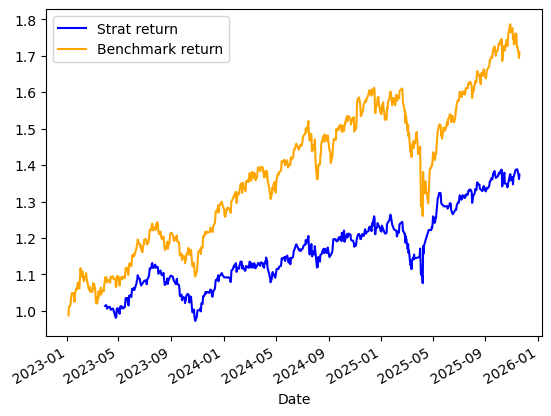

In [146]:
final = cumulative_return(positions, data['Adj Close'])
final.plot(color = 'blue', label = 'Strat return')

const_pos = (positions / positions).replace(0, 1).fillna(1)
comp_chart = cumulative_return(const_pos, data['Adj Close'])
comp_chart.plot(color = 'orange', label = 'Benchmark return')
print(positions['2023-12-1':'2024-1-1'])
print(final.loc['2023-12-1':'2024-1-1'])
print(data['Adj Close'].loc['2023-12-10':'2023-12-20'])
plt.legend()
plt.show()

<Axes: xlabel='Date'>

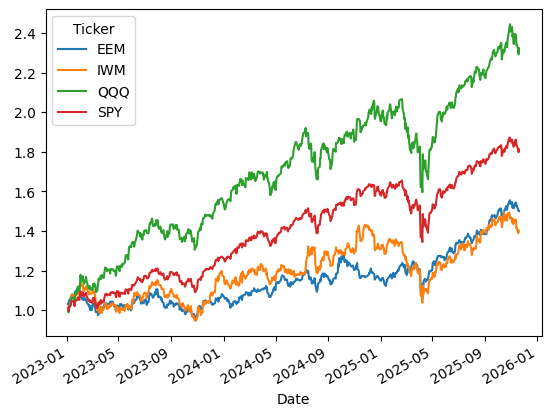

In [147]:
(1 + data['Adj Close'].pct_change()).cumprod().plot()